In [47]:
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Predict model performance

In [48]:
import pandas as pd
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

In [49]:
DATA_PATH = 'data/aggregated/experiments.csv'

Data

In [50]:
df = pd.read_csv(DATA_PATH)
df.head(5)

,topology,cells_number,possible_moves,connection_degree,depth,mean_log2_max_tile
0,hex,19,6,4.11,2,11.275
1,hex,19,6,4.11,1,11.105
2,hex,19,6,4.11,4,13.065
3,hex,19,6,4.11,3,13.130
4,hex,19,6,4.11,0,9.120


Model training

In [51]:
features = ['cells_number', 'possible_moves', 'connection_degree', 'depth']
X = df[features].values
y = df['mean_log2_max_tile'].values

In [52]:
model = Ridge()
model.fit(X, y)

,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


Evaluating

In [53]:
y_pred = model.predict(X)

In [54]:
df['predicted_mean_log2_max_tile'] = y_pred
df_comparison = df[['depth', 'cells_number', 'possible_moves', 'connection_degree', 'mean_log2_max_tile', 'predicted_mean_log2_max_tile']]

Understanding the model

In [55]:
coefs = {}
for feature, coef in zip(features, model.coef_):
    coefs[feature] = coef

intercept = model.intercept_

coefs

{'cells_number': np.float64(0.40173746266628935),
 'possible_moves': np.float64(0.7623526289850459),
 'connection_degree': np.float64(0.33161809311997303),
 'depth': np.float64(0.780967741935484)}

Comparing predicted performance across different depths











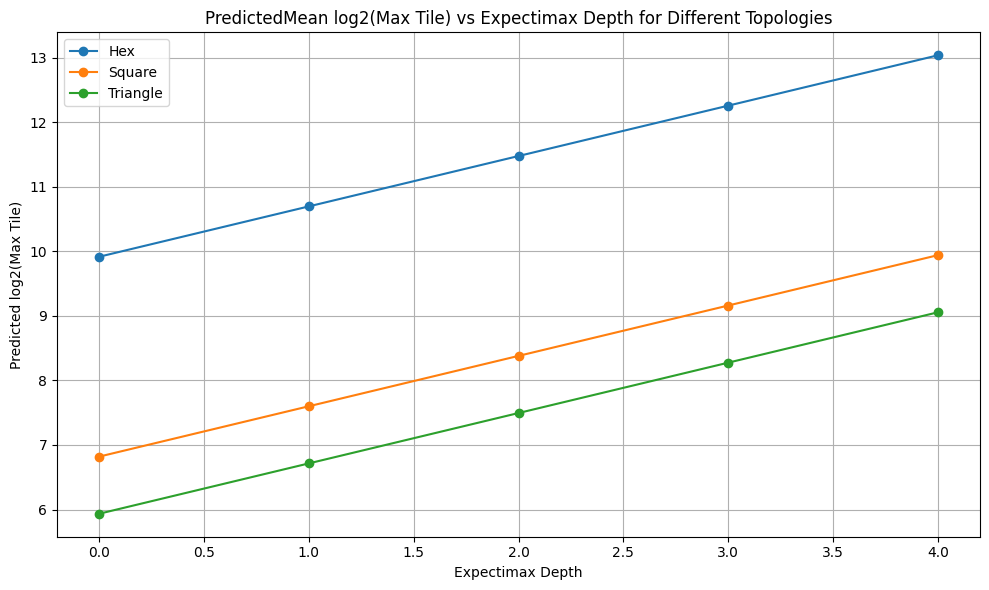

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot for each unique topology
for topo in df["topology"].unique():
    topo_df = df[df["topology"] == topo].sort_values("depth")
    ax.plot(topo_df["depth"], topo_df["predicted_mean_log2_max_tile"], marker='o', label=topo.capitalize())

ax.set_title("Predicted Mean log2(Max Tile) vs Expectimax Depth for Different Topologies")
ax.set_xlabel("Expectimax Depth")
ax.set_ylabel("Predicted log2(Max Tile)")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()